# New Classification model 

New model based on zoomed-in images of the butterflies. Do the bounding box predictions, and zooming in on them, help us get better performance in the classification task?

This notebook should be almost identical to the the '3 - Basic Train' notebook (so we're comparing like-for-like in training approach) except that we are processing the `zoomed` subfolder of zoomed-in images created in notebook number 4. Take a look at notebook 3 if you would like more explanation about the code itself.

In [1]:
from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress

torch.backends.cudnn.benchmark = True
fastprogress.MAX_COLS = 80

n_gpus = num_distrib() or 1
workers = min(8, num_cpus()//n_gpus)

size = 256 # Image size width and height
bs = 32 # Batch size

if torch.cuda.is_available():
    torch.cuda.set_device(0)
    
np.random.seed(13)

In [2]:
BUTTERFLIES_BBOXES_FILEPATH = Path('./butterflies_bboxes.csv')

IMAGE_FOLDER = Path('./butterfly_medium_images/zoomed')

df = pd.read_csv(BUTTERFLIES_BBOXES_FILEPATH)
df = df[df['exclude'] == 0]
df = df.reset_index(drop=True)

In [3]:
# Take first 80% of each class as training data. 
# Prepare a list of indexes that have been selected for the validation set.

train_class_count = int(0.8*df['class'].value_counts().values.min())

valid_idxs = []
for c in df['class'].unique(): # Step through 'gatekeeper_butterfly' and 'meadow_brown_butterfly'
    valid_idxs.extend(df[df['class'] == c].index.values[train_class_count:])
    
print(len(valid_idxs), len(df))

111 541


In [4]:
data = (ImageList.from_df(df, path=IMAGE_FOLDER, folder='', cols='filename')
        .split_by_idx(valid_idxs)
        .label_from_df('class')
        .transform(get_transforms(), size=size)
        .databunch(bs=bs, num_workers=workers)
        .presize(size, scale=(0.75,1))
        .normalize(imagenet_stats))

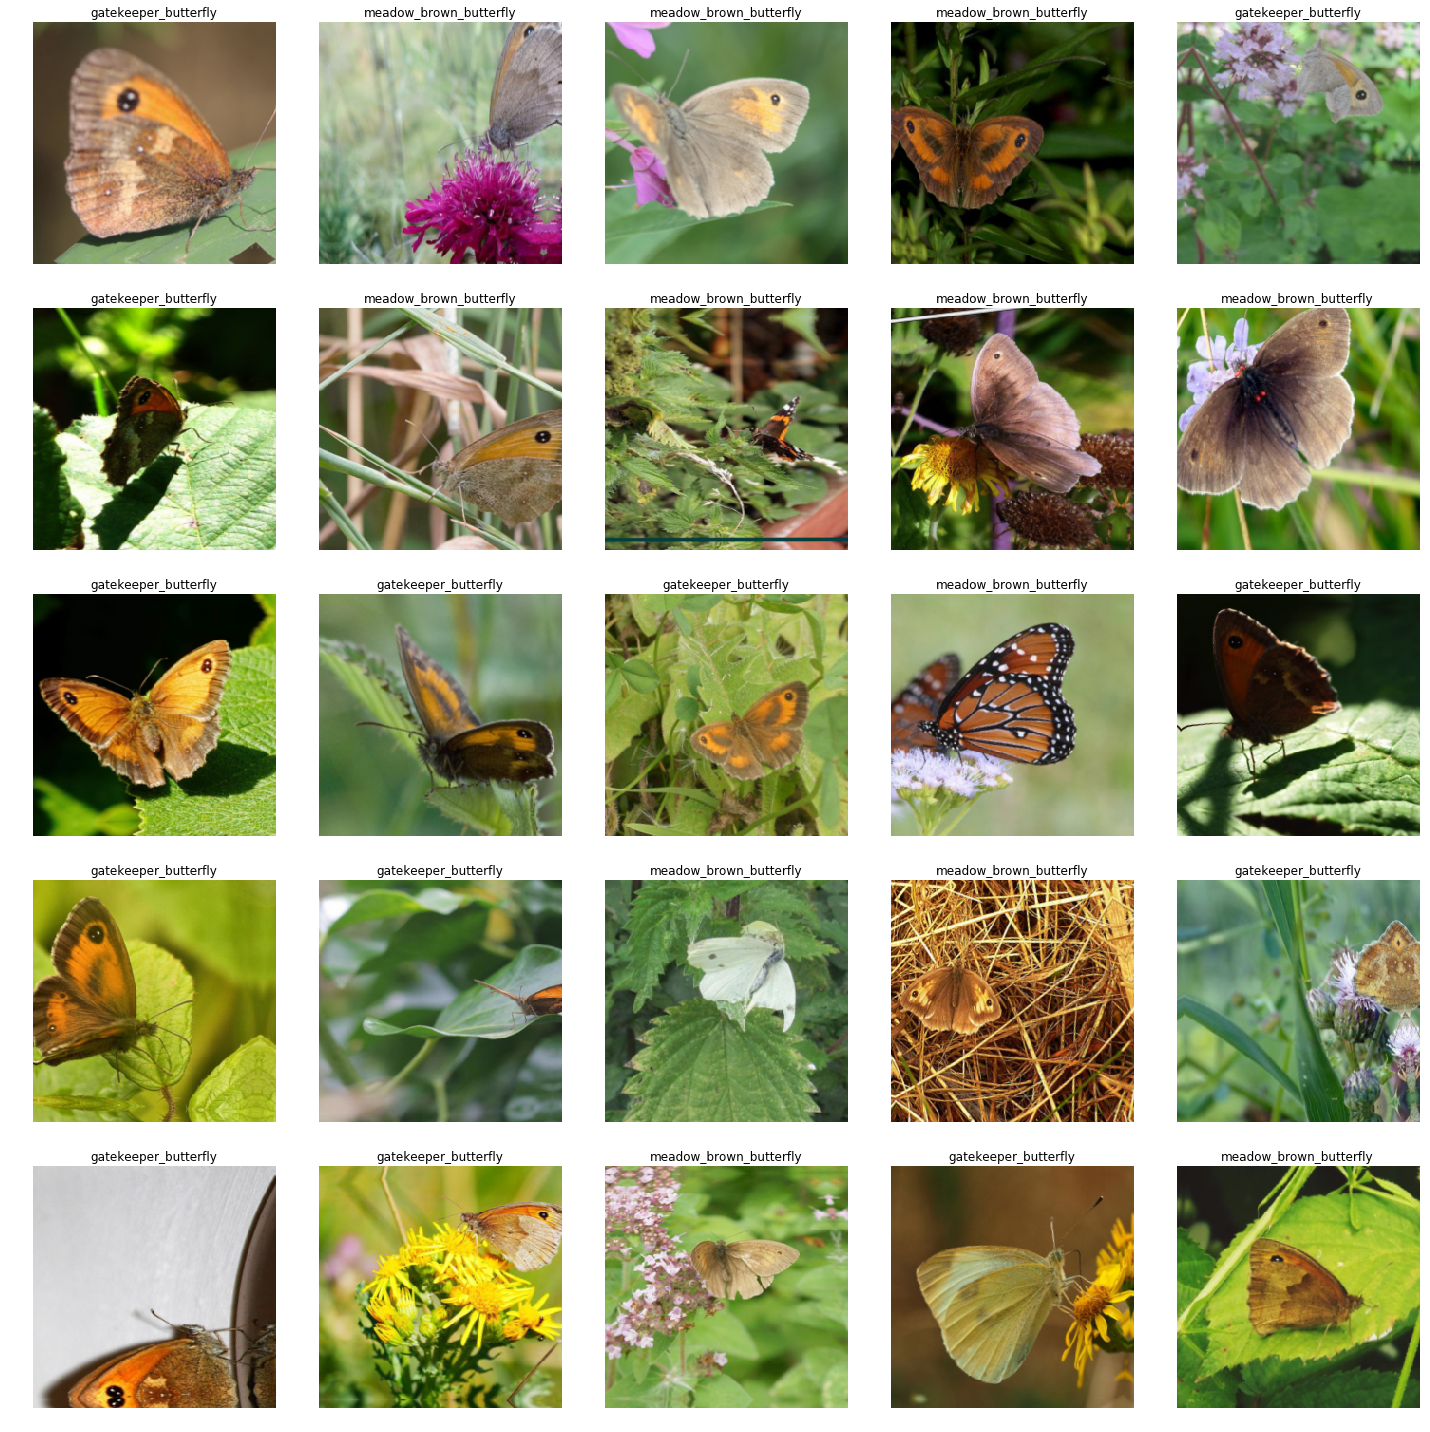

In [5]:
data.show_batch(ds_type=DatasetType.Train)

In [6]:
# Set up training params
lr = 1e-5 # Learning rate
alpha = 0.9 # Alpha
mom = 0.9 # Momentum
eps = 1e-7 # epsilon

# Use Adam optimiser
opt_func = partial(optim.Adam, betas=(mom,alpha), eps=eps)

learn = cnn_learner(data, models.resnet50, metrics=[accuracy, error_rate])

In [7]:
learn.fit_one_cycle(10, lr)

In [8]:
learn.save('butterflies-zoom-1')

In [9]:
#learn.load('butterflies-zoom-1');

In [10]:
lr = 1e-4 # Try a higher learning rate
learn.unfreeze()

In [11]:
learn.fit_one_cycle(5, lr)

In [12]:
learn.save('butterflies-zoom-2')

In [13]:
#learn.load('butterflies-zoom-2');

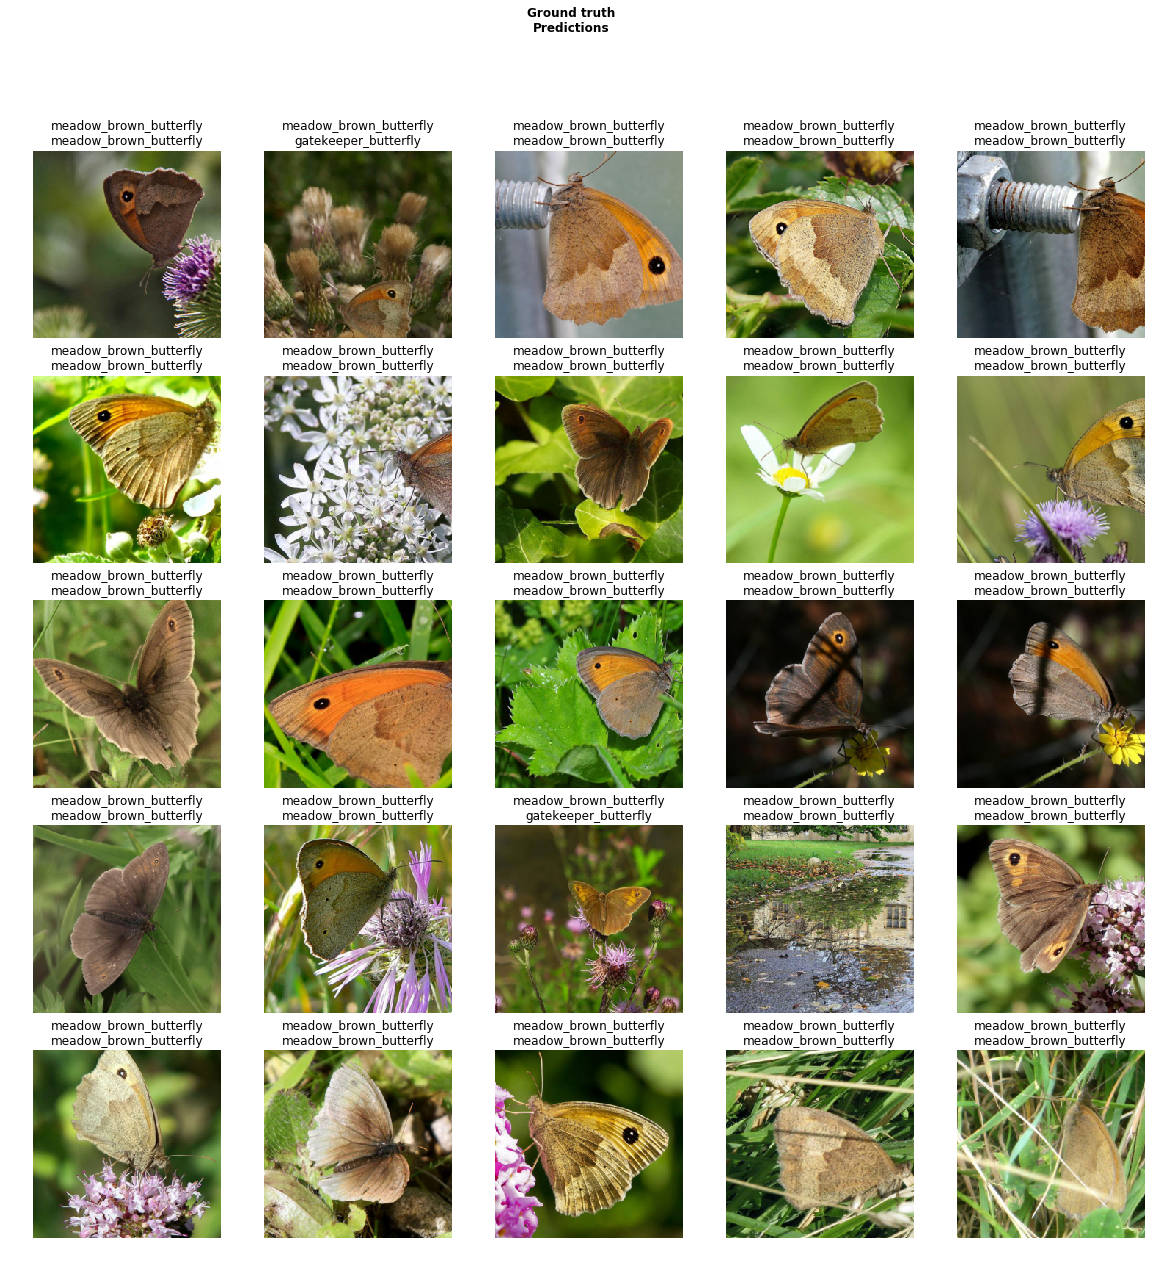

In [14]:
learn.show_results()